In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
import math
from statsmodels.tsa.seasonal import seasonal_decompose 
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping
from keras.layers import ConvLSTM2D
plt.style.use('dark_background')


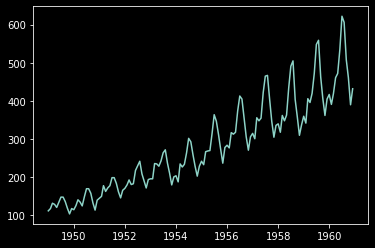

In [38]:
base_df = read_csv('data/AirPassengers.csv')
base_df.rename(columns = {'Month':'Date','#Passengers':'Passengers'},inplace=True)
base_df["Date"] = pd.to_datetime(base_df["Date"])
in_df = base_df.copy(deep=True)
base_df.set_index("Date",inplace = True)
plt.plot(base_df['Passengers'])
ratio = 0.7

In [39]:
if 'Date' in list(in_df.columns):
    del in_df['Date']
else:
    pass

In [40]:
decomposed = seasonal_decompose(base_df['Passengers'],  
                            model ='additive')
residual = decomposed.resid

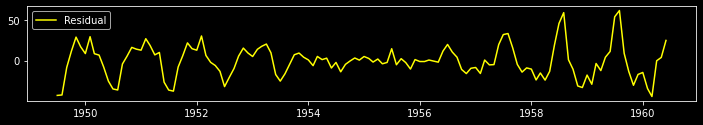

In [41]:
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(residual, label='Residual', color='yellow')
plt.legend(loc='upper left')
plt.show()

In [36]:
dataset = in_df.values
dataset = dataset.astype('float32')

In [37]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [44]:
train_size = int(len(dataset) * ratio)
test_size = len(dataset) - train_size

train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [43]:
def to_sequences(dataset, seq_size=1):
    x = []
    y = []

    for i in range(len(dataset)-seq_size-1):
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])
        
    return np.array(x),np.array(y)


In [ ]:
seq_size = 10
#can be larger for larger datasets, number of previous values the forecast is predicted using

trainX, trainY = to_sequences(train, seq_size)
testX, testY = to_sequences(test, seq_size)

In [ ]:
print("Shape of training set: {}".format(trainX.shape))
print("Shape of test set: {}".format(testX.shape))

In [ ]:
trainX = trainX.reshape((trainX.shape[0], 1,seq_size))
testX = testX.reshape((testX.shape[0], 1, seq_size))

In [ ]:
print('Single LSTM with hidden Dense...')
model = Sequential()
model.add(LSTM(64, input_shape=(None, seq_size)))
model.add(Dense(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20, 
                        verbose=1, mode='auto', restore_best_weights=True)
model.summary()

In [ ]:
model.fit(trainX, trainY, validation_data=(testX, testY),
          verbose=2, epochs=100)

In [ ]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [ ]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [ ]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

In [ ]:
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


In [ ]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[seq_size:len(trainPredict)+seq_size, :] = trainPredict


In [ ]:
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(seq_size*2)+1:len(dataset)-1, :] = testPredict

In [ ]:
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
trainPredictPlot

In [28]:
in_df

,Passengers
0,112
1,118
2,132
3,129
4,121
...,...
139,606
140,508
141,461
142,390


Date
1949-01-01   NaN
1949-02-01   NaN
1949-03-01   NaN
1949-04-01   NaN
1949-05-01   NaN
              ..
1960-08-01   NaN
1960-09-01   NaN
1960-10-01   NaN
1960-11-01   NaN
1960-12-01   NaN
Name: resid, Length: 144, dtype: float64